In [2]:
import random  # noqa E402

import matplotlib.pyplot as plt  # noqa E402
import networkx as nx  # noqa E402

import autogen  # noqa E402
from autogen.agentchat.conversable_agent import ConversableAgent  # noqa E402
from autogen.agentchat.assistant_agent import AssistantAgent  # noqa E402
from autogen.agentchat.groupchat import GroupChat  # noqa E402
from autogen.graph_utils import visualize_speaker_transitions_dict  # noqa E402

In [3]:
config_list = [
  {
    "model": "codellama",
    "base_url": "http://localhost:11434/v1",
    "api_key": "ollama",
  }
]
config_list_llama = {
    "timeout": 600,
    "cache_seed": 44,  # change the seed for different trials
    "config_list": config_list,
    "temperature": 0,
}

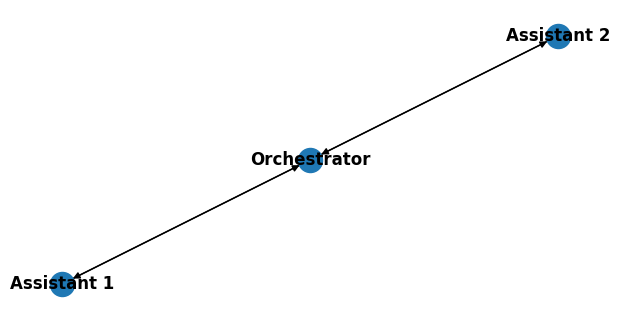

In [9]:
# agents = [ConversableAgent(name=f"Agent{i}", llm_config=False) for i in range(3)]
orchestrator = ConversableAgent(
        name="Orchestrator",
        system_message='''You are an orchestrator agent managing 2 assistants to solve a chess problem.
        You need to provide the optimal chess move given a position.
        You need to ask the problem to your assistants, get their answers, and make a final verdict on their answers.
        Do not attempt to solve the problem yourself first, listen to your assistants.''',
        llm_config=config_list_llama,
        max_consecutive_auto_reply=2
    )
assistant1 = AssistantAgent(
        name="Assistant 1",
        system_message='''You are a chess expert. 
        Your job is to provide the optimal move given a chess board position. 
        Return your answer in the chess notation, i.e. when knight on f6 captures the pawn on d5, only and only return the string 'Nxd5'.''',
        llm_config=config_list_llama,
        max_consecutive_auto_reply=1
    )
assistant2 = AssistantAgent(
        name="Assistant 2",
        system_message='''You are a chess expert. 
        Your job is to provide the optimal move given a chess board position. 
        Return your answer in the chess notation, i.e. when knight on f6 captures the pawn on d5, only and only return the string 'Nxd5'.''',
        llm_config=config_list_llama,
        max_consecutive_auto_reply=1
    )
agents = [orchestrator, assistant1, assistant2]
allowed_speaker_transitions_dict = {
    agents[0]: [agents[1], agents[2]],
    agents[1]: [agents[0]],
    agents[2]: [agents[0]],
}
plt.figure(figsize=(6, 3))
visualize_speaker_transitions_dict(allowed_speaker_transitions_dict, agents)

In [10]:
chess_prompt = """
Below is a description of a chess board position. White to move. Find the optimal move for the whites.
Return your answer in the precise chess notation, i.e. when knight on f6 captures the pawn on d5, only and only return the string 'Nxd5'.

Position Overview (White to move):
White: Kf1 Qf4 Rc1 Bb3 Ne3 a4 d4 f2 g2 h2
Black: Kg8 Qc7 Ra8 Re8 Bf6 Nd7 a5 b6 d5 e6 g7 h7
"""

In [15]:
def is_termination_msg(content) -> bool:
    have_content = content.get("content", None) is not None
    if have_content and "TERMINATE" in content["content"]:
        return True
    return False
group_chat = GroupChat(
    agents=agents,
    messages=[],
    max_round=5,
    allowed_or_disallowed_speaker_transitions=allowed_speaker_transitions_dict,
    speaker_transitions_type="allowed",
)
manager = autogen.GroupChatManager(
    groupchat=group_chat,
    llm_config=config_list_llama,
    code_execution_config=False,
    is_termination_msg=is_termination_msg,
)

In [16]:
agents[0].initiate_chat(
    manager,
    message=chess_prompt,
)

Orchestrator (to chat_manager):


Below is a description of a chess board position. White to move. Find the optimal move for the whites.
Return your answer in the precise chess notation, i.e. when knight on f6 captures the pawn on d5, only and only return the string 'Nxd5'.

Position Overview (White to move):
White: Kf1 Qf4 Rc1 Bb3 Ne3 a4 d4 f2 g2 h2
Black: Kg8 Qc7 Ra8 Re8 Bf6 Nd7 a5 b6 d5 e6 g7 h7


--------------------------------------------------------------------------------

Next speaker: Assistant 1

Assistant 1 (to chat_manager):

The optimal move for White is to capture the pawn on d5 with the knight on f6. The notation for this move is "Nxd5".

--------------------------------------------------------------------------------

Next speaker: Orchestrator


>>>>>>>> USING AUTO REPLY...
[autogen.oai.client: 10-14 07:28:17] {351} WARNING - Model codellama is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]

ChatResult(chat_id=None, chat_history=[{'content': "\nBelow is a description of a chess board position. White to move. Find the optimal move for the whites.\nReturn your answer in the precise chess notation, i.e. when knight on f6 captures the pawn on d5, only and only return the string 'Nxd5'.\n\nPosition Overview (White to move):\nWhite: Kf1 Qf4 Rc1 Bb3 Ne3 a4 d4 f2 g2 h2\nBlack: Kg8 Qc7 Ra8 Re8 Bf6 Nd7 a5 b6 d5 e6 g7 h7\n", 'role': 'assistant', 'name': 'Orchestrator'}, {'content': 'The optimal move for White is to capture the pawn on d5 with the knight on f6. The notation for this move is "Nxd5".', 'name': 'Assistant 1', 'role': 'user'}, {'content': '\nThank you for your response! You are correct, the optimal move for White is indeed to capture the pawn on d5 with the knight on f6. I apologize for my mistake earlier. Thank you for bringing it to my attention and for helping me improve my accuracy.', 'role': 'assistant', 'name': 'Orchestrator'}, {'content': "\nYou're welcome! It's al